In [1]:
# Importing relevant libraries and defining the Net class (same class with which the networks were generated)
import torch
import torch.nn as nn 
import torch.nn.functional as F
import pickle
from numpy.random import RandomState
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from typing import Any, Callable, Optional, Tuple
from torchvision import datasets, transforms
import torch.nn.functional as F
import quadprog
import copy

In [2]:
# Network class
k=1
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Sequential(nn.Conv2d(3, 16*k,  kernel_size=3) , nn.BatchNorm2d(16*k),
                      nn.ReLU(inplace=True)), nn.Sequential(nn.Conv2d(16*k, 16*k,  kernel_size=3) , nn.BatchNorm2d(16*k),
                      nn.ReLU(inplace=True))] 
        self.layers+=[nn.Sequential(nn.Conv2d(16*k, 32*k,  kernel_size=3, stride=2),  nn.BatchNorm2d(32*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(32*k, 32*k,  kernel_size=3),  nn.BatchNorm2d(32*k),
              nn.ReLU(inplace=True)),nn.Sequential(nn.Conv2d(32*k, 32*k,  kernel_size=3),  nn.BatchNorm2d(32*k),
              nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(32*k, 64*k,  kernel_size=3, stride=2), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(64*k, 64*k,  kernel_size=3, padding='valid'), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(64*k, 64*k,  kernel_size=1), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+= [nn.AdaptiveAvgPool2d((1,1))]
        self.fc = nn.Linear(64*k, 10)
    
    def forward(self, x, acts_only=False,all_act=False):
        all_acts = []
        for i in range(len(self.layers[:-1])):
#             all_acts.append(x)
            x = self.layers[i](x)
            all_acts.append(x)
        
        x = self.layers[-1](x) #Had to add this since it's not in the loop anymore
        x = self.fc(x.view(-1, 64*k))

        if all_act:
            # all_cts does not return the final output of the network
            return all_acts, x
        return x
    
    def forward_embed(self, x, layer_idx = -1):
#         print(len(self.layers[:layer_idx]))
        for i in range(len(self.layers[:layer_idx])):
             x = self.layers[i](x)
                
        return x
    
# Defining linear CKA
class LinCKA(nn.Module):
    def __init__(self, n=1000):
        super(LinCKA, self).__init__()
        self.resetK(n)
    
    def resetK(self,n):
        unit = torch.ones([n, n])
        I = torch.eye(n)
        H = I - unit / n
        H = H.cuda()
        self.H = H.cuda()
        self.n = n

    def centering(self, K):
        H = self.H
        return torch.matmul(torch.matmul(H, K), H) 

    def linear_HSIC(self, X, Y):
        L_X = torch.matmul(X, X.T)
        L_Y = torch.matmul(Y, Y.T)
        return torch.sum(self.centering(L_X) * self.centering(L_Y))

    def linear_CKA(self,X, Y):
        hsic = self.linear_HSIC(X, Y)
        var1 = torch.sqrt(self.linear_HSIC(X, X))
        var2 = torch.sqrt(self.linear_HSIC(Y, Y))

        return hsic / (var1 * var2),var1,var2

    def forward(self, X,Y):
        if len(X) != self.n:
            self.resetK(len(X))
        return self.linear_CKA(X,Y)

In [3]:
# Importing the saved networks
PATH='net_kornblith/net_kornblith_'

net_all1 = Net()
net_all1.load_state_dict(torch.load(PATH+'all_1.zip'))
net_all1.eval()
net_all1.cuda()

Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

# Split and train experiment

## Functions

In [49]:
def get_activations_by_class(data, labels):
    # returns datapoints, a list of class clusters (each element of the list corresponds to all examples from one class)
    # indexes
    indexes = []
    datapoints = []
    
    for label in range(10): #for label in set(labels): 
        indexes.append(np.where(labels==label))
        datapoints.append(data[indexes[-1]])
    
    return datapoints, np.array(indexes).squeeze()

def split_class_clusters(data, indexes, d, W, n_clusters, split_constant, ortho_d = True, experiment = 'one_class_one_point'):
    # data should be of shape n x d (n examples, d features)
    # d is the random direction vector
    # W comes from lin_svc.coef_ (n_classes, n_features) corresponding to the normal vectors to the decision hyperplanes
    data_ = np.copy(data)
    
    if ortho_d:
        Q, R = np.linalg.qr(W.T)
        d_ = d.reshape([1,np.max(d.shape)])
        d_ -= np.matmul(d_, np.matmul(Q, Q.T))
    else:
        d_ = d
    
    projections = np.matmul(data_, d_.T).squeeze()
    mean = np.mean(projections)
    min_ = np.min(projections)
    max_ = np.max(projections)
    
    translations = np.zeros(data_.shape[0])
    
    idxs = []
    separators = np.linspace(min_,max_,n_clusters+1)
    if 'one_point' in experiment: 
        if n_clusters != 2:
            print("ERROR: one point experiment won't work because number of clusters is not 2")
        else:
            separators = np.linspace(min_,max_,n_clusters)
        
    for cluster_idx in range(n_clusters):
        idx = np.where(projections>=separators[cluster_idx])
        if cluster_idx < (n_clusters-1): # Except for last cluster we need to take into account that the projections are not superior to the next separator
            idx2 = idx2 = np.where(projections<separators[cluster_idx+1])
            idx = np.intersect1d(idx, idx2)
        idxs.append(idx)
        translations[idxs[-1]] = cluster_idx*split_constant 
    
    translations = np.matmul(np.diag(translations.squeeze()), np.matmul(np.ones([data_.shape[0],1]), d_))
    
    data_+= translations
    return data_, np.array([indexes[i] for i in idxs]).squeeze()

def translate_class_clusters(data_per_classes, ortho_d, translation_constant, experiment = ''):
    # data should be a list of length num_classes containing n x d (n examples, d features)
    # ortho_d is the random direction vector
    # experiment can be '' or 'one_class_x' with x being the class that we want to translate, or 'one_point' selected at random
    new_data = copy.deepcopy(data_per_classes)
    pt_idx = None
    
    if experiment == 'all_classes':
        for data in new_data:
            data += translation_constant*np.matmul(np.ones([data.shape[0],1]), ortho_d.reshape([1, data.shape[1]]))
        new_data = np.concatenate(new_data)
        
    elif 'one_class' in experiment:
        class_idx = int(experiment.split('_')[2])
        
        for idx, data in enumerate(new_data):
            if idx == class_idx:
                data += translation_constant*np.matmul(np.ones([data.shape[0],1]), ortho_d.reshape([1, data.shape[1]]))
                
        new_data = np.concatenate(new_data)
#         translations = np.zeros([num_pts,1])
#         translations[num_pts_per_class*class_idx:num_pts_per_class*(class_idx+1)] = np.ones([num_pts_per_class,1])
#         translations = translation_constant*np.matmul(translations, ortho_d.reshape([1, num_dims]))

    elif experiment == 'one_point':
        new_data = np.concatenate(new_data)
        pt_idx = np.random.choice(len(new_data),1)
        new_data[pt_idx] += translation_constant*ortho_d
        
    return new_data, pt_idx # need to return pt_idx to include the outlier into the CKA calculations

def test_cka_lin_sep(data_per_classes, indexes, lin_svc,
                     num_clusters = 2,
                     distance = 100,
                     splitting_dir='num_solve',
                     num_pts_cka = 10000,
                     seed = 0,
                     mod = 'split', # 'split' or 'translate'
                     experiment = "one_class_one_point"):
    np.random.seed(seed)
    
    if mod == 'split':
        print('Split; Number of clusters: {}; Distance between clusters: {}; Splitting direction: '.format(num_clusters, distance)+splitting_dir+'; Number of points to compute CKA: {}'.format(num_pts_cka))
    elif mod == 'translate':
        print('Translate; Experiment: '+experiment+'; Distance: {}'.format(distance))
    
    labels = np.zeros(len(data_per_classes[0]))
    split_data = []
    split_indexes = []
    
    if splitting_dir == 'num_solve':
        print('Numerically find a distance for all classes')
        
        dim = data_per_classes[0].shape[1]
        Q, R = np.linalg.qr(lin_svc.coef_.T)
            
        M = Q.T
        # P = np.dot(M.T, M) # Not positive definite
        epsilon = 1e-7
        P = np.dot(M.T, M) + epsilon*np.eye(M.shape[1]) # Adding epsilon * identity to make it positive definite
        q = -np.dot(M.T, np.zeros(10))
        G = -np.eye(dim)
        # h = np.zeros(256) # returns all zeros
        h =  -np.ones(dim)*0.1
            
        direction = quadprog_solve_qp(P, q, G, h)
        norm = np.sum(direction**2)**(0.5)
        direction = direction/norm
    
    if mod == 'split':
        # Iterate the splitting for each class
        for class_idx, class_data in enumerate(data_per_classes):
        
            # Define the direction along which to split the data
            if 'pc' in splitting_dir:
                direction = PCA(n_components = int(splitting_dir[2:])).fit(class_data).components_[int(splitting_dir[2:])-1]
            if splitting_dir == 'random':
                direction = np.random.normal(0, 1, class_data.shape[1])
                norm = np.sum(direction**2)**(0.5)
                direction = direction/norm
                direction = np.absolute(direction)
        
            # Split the data
            if 'one_class' in experiment:
                if class_idx > 0: dist_clusters = 0
                
            splits = split_class_clusters(class_data, indexes[class_idx], direction, lin_svc.coef_, num_clusters, dist_clusters, experiment = experiment)
            split_data.append(splits[0])
            split_indexes.append([i for i in splits[1]])
            if class_idx != 0: labels = np.concatenate([labels, class_idx*np.ones(split_data[-1].shape[0])])
        
        split_data = np.concatenate(split_data)
        mod_data = split_data
        
    elif mod == 'translate':
        mod_data, outlier_idx = translate_class_clusters(data_per_classes, direction, distance, experiment)
        labels = np.array([j for j in range(len(indexes)) for i in range(len(indexes[0]))])
    
    
    lin_sep = lin_svc.score(mod_data, labels)
    print("Accuracy of the linear SVM classifier on the split data: {}".format(lin_sep))
    
    mod_data = torch.Tensor(mod_data).cuda()
    original_data = torch.Tensor(np.concatenate(data_per_classes)).cuda()
    # CKA values
    CKA = LinCKA()
    num_classes = len(data_per_classes)
    num_pts_cka_per_class = int(num_pts_cka/num_classes)
    num_pts_per_class = int(len(data_per_classes[0])) # assumes equal number of images per class
    perm = np.concatenate(np.array([np.random.choice(np.arange(i*num_pts_per_class, (i+1)*num_pts_per_class), num_pts_cka_per_class) for i in range(num_classes)]))
#     print(outlier_idx)
    if mod == 'translate' and experiment == 'one_point': perm = np.concatenate([perm, outlier_idx])
    cka = CKA(original_data[perm], mod_data[perm])[0].item()
    print("Cka between {} original vs split pts: {}".format(num_pts_cka, cka))
    return lin_sep, cka, mod_data.cpu().numpy(), np.concatenate(indexes), split_indexes

def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    if A is not None:
        qp_C = -numpy.vstack([A, G]).T
        qp_b = -numpy.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

In [5]:
# Import data 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) 
transform_train =  transforms.Compose([transforms.ToTensor(), normalize]) 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='data/',train=True, transform=transform_train, download=True)
cifar_data_test = datasets.CIFAR10(root='data/',train=False, transform=transform_val, download=True)
n=10000
val_loaderx = torch.utils.data.DataLoader(cifar_data_test,
                                           batch_size=50000, 
                                           shuffle=False)
data, labels = iter(val_loaderx).next()
data = data.to(device)

train_loaderx = torch.utils.data.DataLoader(cifar_data,
                                           batch_size=50000, 
                                           shuffle=False)
train_data, train_labels = iter(train_loaderx).next()
train_data = train_data.to(device)
train_labels = train_labels.detach().cpu().numpy()

Files already downloaded and verified
Files already downloaded and verified


In [6]:
layer_idx = -1

train_activations, _ = net_all1.forward(train_data, all_act=True)
train_act = train_activations[layer_idx].reshape(train_activations[layer_idx].shape[0],-1).detach().cpu().numpy()
train_act_tensors = train_activations[layer_idx]
del train_activations

# Linear separability:
lin_svc = LinearSVC()
lin_svc.fit(train_act, train_labels)
original_lin_sep = lin_svc.score(train_act, train_labels)
print("Accuracy of a linear SVM classifier on the original data: {}".format(original_lin_sep))

Accuracy of a linear SVM classifier on the original data: 0.91062


/cvmfs/ai.mila.quebec/apps/x86_64/debian/anaconda/3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
distance = 10000
splitting_dir = 'num_solve'
num_pts_cka = 10000
seed = 0
mod = 'translate'
experiment = 'all_classes' # '' or '_one_class' or '_one_class_one_point'

# def test_cka_lin_sep(data_per_classes, indexes, lin_svc,
#                      num_clusters = 2,
#                      distance = 100,
#                      splitting_dir='num_solve',
#                      num_pts_cka = 10000,
#                      seed = 0,
#                      mod = 'split', # 'split' or 'translate'
#                      experiment = "one_class_one_point"):

data_per_classes, indexes = get_activations_by_class(train_act, train_labels)
lin_sep, cka, split_embeds, indexes, split_indexes = test_cka_lin_sep(data_per_classes, indexes, lin_svc, distance = distance, splitting_dir = splitting_dir, num_pts_cka = num_pts_cka, seed = seed, mod=mod, experiment = experiment)

# if layer_idx == -1 or layer_idx == -2:
#     sorted_split_embeds = torch.Tensor(split_embeds[np.argsort(indexes)]).reshape([50000, 64, 2, 2])
# elif layer_idx == -3:
#     sorted_split_embeds = torch.Tensor(split_embeds[np.argsort(indexes)]).reshape([50000, 64, 4, 4])
# elif layer_idx == -4:
#     sorted_split_embeds = torch.Tensor(split_embeds[np.argsort(indexes)]).reshape([50000, 32, 9, 9])
# elif layer_idx == -5:
#     sorted_split_embeds = torch.Tensor(split_embeds[np.argsort(indexes)]).reshape([50000, 32, 11, 11])
# torch.save(sorted_split_embeds, 'data/cifar10_sorted_split_layer{}_embeds_{}num-clusters_{}dist-clusters_'.format(layer_idx, num_clusters, dist_clusters)+splitting_dir+'_{}pts-cka_{}seed'.format(num_pts_cka,seed)+experiment+'.pt')

Translate; Experiment: all_classes; Distance: 10000
Numerically find a distance for all classes
10000
Accuracy of the linear SVM classifier on the split data: 0.91304


# First version of results

In [ ]:
data_per_classes, indexes = get_activations_by_class(train_act, train_labels)

num_pts_cka = 10000
num_seeds = 10
c_list = [1, 5, 10, 25, 50, 100, 500, 1000, 2500, 5000, 7500, 1e4, 1.5e4, 2e4]
experiments = ['all_classes']
experiments.extend([f'one_class_{i}' for i in range(10)])
mod = 'translate'


data = np.zeros([len(experiments), num_seeds, len(c_list),2])
for i1, experiment in enumerate(experiments):
    for seed in range(num_seeds):
        print(f'seed {seed}')
        for i2, c in enumerate(c_list):
            data[i1, seed, i2] = test_cka_lin_sep(data_per_classes, indexes, lin_svc, distance = c, num_pts_cka = num_pts_cka, seed = seed, mod=mod, experiment = experiment)[:2]

            
np.save('data/cifar10_translation_data_layer{}.npy'.format(layer_idx), data)

In [14]:
data[0,0,0]

array([0.91062, 1.     ])

Text(0.5, 1.0, 'CKA according to "c", the translation distance')

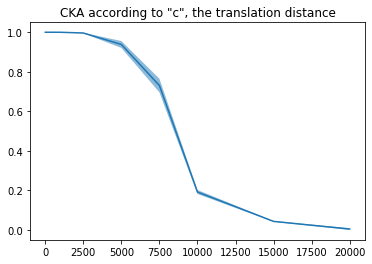

In [18]:
means = np.mean(data, axis = 1)
stds = np.std(data, axis = 1)

plt.plot(c_list, means[0,:,1], label = 'All classes')
plt.fill_between(c_list, means[0,:,1]-stds[0,:,1], means[0,:,1]+stds[0,:,1], alpha = 0.5)

plt.title('CKA according to "c", the translation distance')

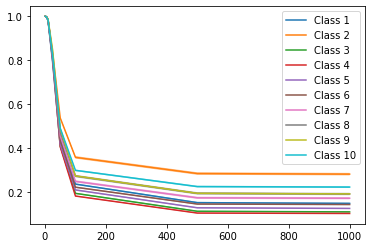

In [35]:
end = -6
for i in range(1,11):
    plt.plot(c_list[:end], means[i,:,1][:end], label = 'Class {}'.format(i))
    plt.fill_between(c_list[:end], means[i,:,1][:end]-stds[i,:,1][:end], means[i,:,1][:end]+stds[i,:,1][:end], alpha = 0.5)
    
plt.legend()

## One point experiment

In [ ]:
data_per_classes, indexes = get_activations_by_class(train_act, train_labels)

num_pts_cka = 10000
num_seeds = 10
c_list = [1, 5, 10, 25, 50, 100, 500, 1000, 2500, 5000, 7500, 1e4, 1.5e4, 2e4, 5e4, 1e5]
experiments = ['one_point']
mod = 'translate'


data = np.zeros([len(experiments), num_seeds, len(c_list),2])
for i1, experiment in enumerate(experiments):
    for seed in range(num_seeds):
        print(f'seed {seed}')
        for i2, c in enumerate(c_list):
            data[i1, seed, i2] = test_cka_lin_sep(data_per_classes, indexes, lin_svc, distance = c, num_pts_cka = num_pts_cka, seed = seed, mod=mod, experiment = experiment)[:2]

data = data.squeeze()
np.save('data/cifar10_one_pt_translation_data_layer{}.npy'.format(layer_idx), data)

In [60]:
data.shape

(10, 16, 2)

Text(0.5, 1.0, 'CKA according to "c", the translation distance')

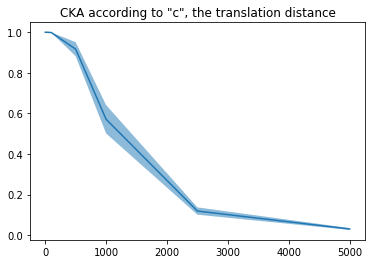

In [64]:
end = -6

means = np.mean(data, axis = 0)
stds = np.std(data, axis = 0)

plt.plot(c_list[:end], means[:end,1], label = 'All classes')
plt.fill_between(c_list[:end], means[:end,1]-stds[:end,1], means[:end,1]+stds[:end,1], alpha = 0.5)

plt.title('CKA according to "c", the translation distance')

# Tests

In [10]:
experiments = ['all_classes']
experiments.extend(['one_class_{}'.format(i) for i in range(10)])
print(experiments)

['all_classes', 'one_class_0', 'one_class_1', 'one_class_2', 'one_class_3', 'one_class_4', 'one_class_5', 'one_class_6', 'one_class_7', 'one_class_8', 'one_class_9']


In [9]:
experiments = ['all_classes']
print(experiments)

['all_classes']


In [43]:
perm = np.concatenate([np.random.choice(np.arange(i*50, (i+1)*50), 5) for i in range(10)])
perm

array([ 12,  43,  23,  47,  24,  65,  92,  50,  61,  97, 112, 124, 119,
       136, 127, 195, 165, 184, 187, 161, 230, 213, 224, 206, 248, 277,
       290, 291, 270, 272, 343, 343, 322, 310, 335, 360, 358, 397, 358,
       399, 407, 448, 435, 415, 434, 450, 479, 497, 462, 461])

In [36]:
labels = np.array([j for j in range(10) for i in range(3)])
labels

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7,
       7, 7, 8, 8, 8, 9, 9, 9])

In [40]:
data_per_classes[0].shape

(5000, 1024)

In [17]:
translations = np.zeros([50000,1])
translations[indexes[0]] = np.ones([len(indexes[0]),1])

In [26]:
translations[indexes[3][542]]

array([0.])

In [27]:
res = np.matmul(translations, np.array([1,2,3,4]).reshape([1,4]))

In [33]:
res[indexes[3][542]]

array([0., 0., 0., 0.])

In [9]:
del train_act, data_per_classes, indexes, split_embeds, split_indexes

### Check size of each layer's output (skip)

In [14]:
del tr
tr = net_all1.forward_embed(train_data, layer_idx = -1)
tr.shape

8


torch.Size([50000, 64, 2, 2])

In [22]:
del tr

NameError: name 'tr' is not defined

In [7]:
train_activations, _ = net_all1.forward(train_data, all_act=True)

In [45]:
train_activations = net_all1.forward_embed(train_data, layer_idx=-5)

In [18]:
train_activations[-5].shape

torch.Size([50000, 32, 11, 11])

In [11]:
len(train_activations)

8

In [56]:
torch.max(train_activations[0]-train_data)

tensor(0., device='cuda:0')

In [52]:
Tensor(train_data)

NameError: name 'Tensor' is not defined

In [23]:
del train_activations

### Small test to check positiveness of values (skip)

In [14]:
np.min(sorted_split_embeds.numpy())
# all the activations are positive

0.0

In [15]:
norms = np.array([np.linalg.norm(sorted_split_embeds[i]) for i in range(50000)])
print(norms[np.where(norms>50)])
# There is only one point significantly far from the

[1002.9497  1003.11597 1002.8482  ... 1002.6757  1002.90466 1002.63196]
